# Ordinal Regression

Some data are discrete but intrinsically **ordered**, these are called [**ordinal**](https://en.wikipedia.org/wiki/Ordinal_data) data. One example is the [likert scale](https://en.wikipedia.org/wiki/Likert_scale) for questionairs ("this is an informative tutorial": 1. strongly disagree / 2. disagree / 3. neither agree nor disagree / 4. agree / 5. strongly agree). Ordinal data is also ubiquitous in the medical world (e.g. the [Glasgow Coma Scale](https://en.wikipedia.org/wiki/Glasgow_Coma_Scale) for measuring neurological disfunctioning). 

This poses a challenge for statistical modeling as the data do not fit the most well known modelling approaches (e.g. linear regression). Modeling the data as [categorical](https://en.wikipedia.org/wiki/Categorical_distribution) is one possibility, but it disregards the inherent ordering in the data, and may be less statistically efficient. There are multiple appoaches for modeling ordered data. Here we will show how to use the OrderedLogistic distribution using cutpoints that are sampled from Improper priors, from a Normal distribution and induced via categories' probabilities from Dirichlet distribution. For a more in-depth discussion of Bayesian modeling of ordinal data, see e.g. [Michael Betancourt's Ordinal Regression case study](https://betanalpha.github.io/assets/case_studies/ordinal_regression.html) 

**References:**
 1. Betancourt, M. (2019), “Ordinal Regression”, (https://betanalpha.github.io/assets/case_studies/ordinal_regression.html)

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
from jax import numpy as np, random
import numpyro
from numpyro import sample,handlers
from numpyro.distributions import (Categorical, Dirichlet, ImproperUniform, Normal, OrderedLogistic,
                                   TransformedDistribution, constraints, transforms)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

import pandas as pd
import seaborn as sns
assert numpyro.__version__.startswith('0.7.2')

# Data Generation

First, generate some data with ordinal structure

In [3]:
simkeys  = random.split(random.PRNGKey(1), 2)
nsim     = 50
nclasses = 3
Y        = Categorical(logits=np.zeros(nclasses)).sample(simkeys[0], sample_shape=(nsim,))
X        = Normal().sample(simkeys[1], sample_shape = (nsim,))
X       += Y

print("value counts of Y:")
df = pd.DataFrame({'X': X, 'Y': Y})
print(df.Y.value_counts())

for i in range(nclasses):
    print(f"mean(X) for Y == {i}: {X[np.where(Y==i)].mean():.3f}")

value counts of Y:
1    19
2    16
0    15
Name: Y, dtype: int64
mean(X) for Y == 0: 0.042
mean(X) for Y == 1: 0.832
mean(X) for Y == 2: 1.448


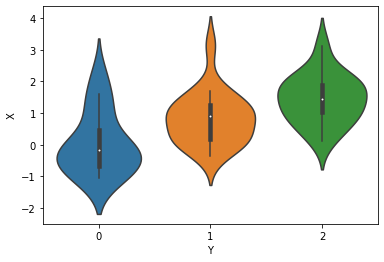

In [4]:
sns.violinplot(x='Y', y='X', data=df);

# Improper Prior

We will model the outcomes Y as coming from an OrderedLogistic distribution, conditional on X. The `OrderedLogistic` distribution in numpyro requires ordered cutpoints. We can use the `ImproperUnifrom` distribution to introduce a parameter with an arbitrary support that is otherwise completely uninformative, and then add an `ordered_vector` constraint.

In [5]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 254.82it/s, 7 steps of size 5.56e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.45      0.34      1.46      0.90      2.02    396.42      1.01
    c_y[0]     -0.08      0.39     -0.07     -0.69      0.56    477.42      1.00
    c_y[1]      2.18      0.49      2.17      1.44      3.04    460.70      1.01

Number of divergences: 0


The `ImproperUniform` distribution allows us to use parameters with constraints on their domain, without adding any additional information e.g. about the location or scale of the prior distribution on that parameter.

If we want to incorporate such information, for instance that the values of the cut-points should not be too far from zero, we can add an additional `sample` statement that uses another prior, coupled with an `obs` argument. In the example below we first sample cutpoints `c_y` from the `ImproperUniform` distribution with `constraints.ordered_vector` as before, and then `sample` a dummy parameter from a `Normal` distribution while conditioning on `c_y` using `obs=c_y`. Effectively, we've created an improper / unnormalized prior that results from restricting the support of a `Normal` distribution to the ordered domain

In [6]:
def model2(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    sample('c_y_smp', Normal(0,1), obs=c_y)
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model2)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 253.05it/s, 7 steps of size 5.31e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.23      0.31      1.23      0.64      1.68    501.31      1.01
    c_y[0]     -0.24      0.34     -0.23     -0.76      0.38    492.91      1.00
    c_y[1]      1.77      0.40      1.76      1.11      2.42    628.46      1.00

Number of divergences: 0


# Proper Prior

If having a proper prior for those cutpoints `c_y` is desirable (e.g. to sample from that prior and get [prior predictive](https://en.wikipedia.org/wiki/Posterior_predictive_distribution#Prior_vs._posterior_predictive_distribution)), we can use [TransformedDistribution](http://num.pyro.ai/en/stable/distributions.html#transformeddistribution) with an [OrderedTransform](http://num.pyro.ai/en/stable/distributions.html#orderedtransform) transform as follows.

In [7]:
def model3(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    c_y     = sample("c_y",     TransformedDistribution(Normal(0, 1).expand([nclasses - 1]),
                                                        transforms.OrderedTransform()))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model3)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 244.55it/s, 7 steps of size 5.54e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.40      0.34      1.41      0.86      1.98    300.35      1.03
    c_y[0]     -0.03      0.35     -0.03     -0.57      0.54    396.02      1.00
    c_y[1]      2.06      0.47      2.04      1.26      2.83    475.23      1.01

Number of divergences: 0


# Principled prior with Dirichlet Distribution

It is non-trivial to apply our expertise over the cutpoints in latent space (even more so when we are having to provide a prior before applying the OrderedTransform). 

Natural inclination would be to apply Dirichlet prior model to the ordinal probabilities. We will follow proposal by M.Betancourt ([1], Section 2.2) and use [Dirichlet](http://num.pyro.ai/en/stable/distributions.html#dirichlet) prior model to induce cutpoints indirectly via [Simplex2OrderedTransform](http://num.pyro.ai/en/stable/distributions.html#simplex2orderedtransform). 
This approach should be advantageous when there is a need for strong prior knowledge to be added to our Ordinal model, eg, when one of the categories is missing in our dataset or when some categories are strongly separated (leading to non-identifiability of the cutpoints). Moreover, such parametrization allows us to sample our model and conduct prior predictive checks (unlike `model1` with `ImproperUniform`).

We can sample cutpoints directly from `TransformedDistribution(Dirichlet(concentration),transforms.Simplex2OrderedTransform(anchor_point))`. However, if we use the Transform within the `reparam handler` context, we can capture not only the induced cutpoints, but also the sampled Ordinal probabilities implied by the `concentration` parameter. `anchor_point` is a nuisance parameter to improve identifiability of our transformation (for details please see [1], Section 2.2)

Please note that we cannot compare latent cutpoints or b_X_eta separately across the various models as they are inherently linked.

In [8]:
# We will apply a nudge towards equal probability for each category (corresponds to equal logits of the true data generating process)
concentration=np.ones((nclasses,))*10.0

In [9]:
def model4(X, Y, nclasses,concentration,anchor_point=0.0):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    
    with handlers.reparam(config={'c_y': TransformReparam()}):
        c_y=sample("c_y", TransformedDistribution(Dirichlet(concentration), 
                                                               transforms.Simplex2OrderedTransform(anchor_point)))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model4)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses,concentration)
# with exclude_deterministic=False, we will also show the ordinal probabilities sampled from Dirichlet (vis. `c_y_base`)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 1000/1000 [00:05<00:00, 167.18it/s, 7 steps of size 6.88e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    b_X_eta      1.00      0.27      1.00      0.57      1.43    338.00      1.00
     c_y[0]     -0.42      0.25     -0.42     -0.84     -0.03    425.85      1.00
     c_y[1]      1.33      0.30      1.32      0.84      1.81    626.08      1.00
c_y_base[0]      0.40      0.06      0.40      0.30      0.49    435.16      1.00
c_y_base[1]      0.39      0.06      0.39      0.30      0.48    462.32      1.00
c_y_base[2]      0.21      0.05      0.21      0.13      0.29    566.56      1.00

Number of divergences: 0
